# Лабораторная работа №4 “Нейронные сети”


In [39]:
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

## 1. Загрузите данные ex4data1.mat из файла.

In [40]:
mat = loadmat('data/ex4data1.mat')
x_train, y_train = mat['X'], mat['y']
y_train = y_train.reshape(y_train.shape[0])

# replace all 10 to 0
y_train = np.where(y_train == 10, 0, y_train)

## 2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?

In [41]:
weights = loadmat('data/ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

Входной слой: 400 нейронов,
Промежуточный слой: 25 нейронов,
Выходной слой: 10 нейронов.
theta0 - bias unit

## 3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации.

In [42]:
s_L = [400, 25, 10]

In [43]:
def sigmoid(z):
    return 1 / (1 + np.e ** (-z))

def insert_ones(x):
    if len(x.shape) == 1:
        return np.insert(x, 0, 1)
    return np.column_stack((np.ones(x.shape[0]), x))

def forward_propagation(x, thetas, cache=False):
    cur_activation = x.copy()
    activations = [cur_activation]

    for theta_i in thetas:
        temp_a = insert_ones(cur_activation)
        z_i = theta_i.dot(temp_a.T).T
        cur_activation = sigmoid(z_i)
        if cache:
            activations.append(cur_activation)

    return activations if cache else cur_activation

In [ ]:
def unroll(weights):
    result = np.array([])

    for theta in weights:
        result = np.concatenate((result, theta.flatten()))

    return result

def roll(weights):
    weights = np.array(weights)
    thetas = []
    left = 0

    for i in range(len(s_L) - 1):
        x, y = s_L[i + 1], s_L[i] + 1
        right = x*y
        thetas.append(weights[left:left + right].reshape(x, y))
        left = right

    return thetas

## 4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [44]:
def accuracy(predicted, y):
    correct_result_count = np.count_nonzero(predicted.argmax(axis=1) - y)
    return 1 - correct_result_count / y.shape[0]

In [45]:
weights = [theta1, theta2]
predicted = forward_propagation(x_train, weights)
accuracy(predicted, y_train)

0.0011999999999999789

Как видно из результатов нейронная сеть не обучена. В случае лог регрессии точность была выше 95%.

## 5. Перекодируйте исходные метки классов по схеме one-hot.

In [46]:
# |class|    |class1|class2|
# |1    | => |1     |0     |
# |2    |    |0     |1     |

In [47]:
def one_hot(y, classes_count=10):
    y_extended = np.zeros((len(y), classes_count))

    for i, y_i in enumerate(y):
        y_extended[i][y_i] = 1

    return y_extended

In [48]:
y_one_hot = one_hot(y_train)

## 6. Реализуйте функцию стоимости для данной нейронной сети.

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))]$

In [49]:
ONE = 1.0 + 1e-15

def cost_func(X, y, weights):
    total_cost = 0
    K = y.shape[1]
    hyp = forward_propagation(X, weights)
    for k in range(K):
        y_k, hyp_k = y[:, k], hyp[:, k]
        cost_trues =  y_k * np.log(hyp_k)
        cost_falses = (1 - y_k) * np.log(ONE - hyp_k)
        cost = cost_trues + cost_falses
        total_cost += cost
    return -total_cost.sum() / y.shape[0]

## 7. Добавьте L2-регуляризацию в функцию стоимости.

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

In [50]:
def cost_func_regularized(X, y, weights, reg_L=1):
    weights = roll(weights)
    reg = 0
    cost = cost_func(X, y, weights)

    for theta in weights:
        theta_R = theta[:, 1:]
        reg += (theta_R ** 2).sum()

    return cost + (reg_L / 2 / y.shape[0]) * reg

## 8. Реализуйте функцию вычисления производной для функции активации.

In [51]:
def activation_der(act):
    return act * (1 - act)

## 9. Инициализируйте веса небольшими случайными числами.


In [72]:
def init_weights_for_layer(l_in, l_out):
    epi = (6**1/2) / (l_in + l_out)**1/2
    
    return np.random.rand(l_out, l_in +1) * (2*epi) - epi

In [73]:
def init_weights():
    weights = []

    for idx in range(len(network_struct) - 1):
        layer_out = network_struct[idx + 1] + 1
        layer_in = network_struct[idx]
        weights.append(init_weights_for_layer(layer_in, layer_out))

    return unroll(weights)

In [74]:
INIT_EPS = 1e-2

def initialize_weights():
    weights = []

    for i in range(len(s_L) - 1):
        theta = np.random.random((s_L[i + 1], s_L[i] + 1)) * 2 * INIT_EPS - INIT_EPS
        weights.append(theta)

    return unroll(weights)

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network

$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$

## 10. Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

In [54]:
def back_prop(X, y, weights, reg_L=0):
    M = y.shape[0]
    L = len(weights)
    act = forward_propagation(X, weights, cache=True)
    Deltas = [np.zeros(theta.shape) for theta in weights]
    
    for i in range(M):
        delta_L = y[i] - act[-1][i]
        deltas = [delta_L]

        for l in reversed(range(1, L)):
            d = np.dot(weights[l].T, deltas[-1]) * activation_der(insert_ones(act[l][i]))
            deltas.append(d[1:])

        deltas = list(reversed(deltas))
        for l in range(L):
            Deltas[l] = Deltas[l] + np.dot(deltas[l].reshape((-1,1)), insert_ones(act[l][i]).reshape((1, -1)))
    
    D = []
    for l, Delta_l in enumerate(Deltas):
        D_l = Delta_l / M
        D_l[:, 1:] += reg_L * weights[l][:, 1:]
        D.append(D_l)
    
    return D

## 11. Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.


In [55]:
GRAD_EPS = 1e-4

def check_gradient(X, y, thetas, D_vec, edge=500):
    def J(theta):
        return cost_func_regularized(X, y, theta)

    N = min(len(thetas), edge)
    grad_approx = np.zeros(N)

    for i in range(N):
        theta_plus, theta_minus = thetas.copy(), thetas.copy()
        theta_plus[i] += GRAD_EPS
        theta_minus[i] -= GRAD_EPS
        grad_approx[i] = (J(theta_plus) - J(theta_minus)) / (2 * GRAD_EPS)

    return np.allclose(grad_approx, D_vec[:N], atol=1)

In [57]:
Deltas = back_prop(x_train, y_one_hot, weights)

check_gradient(x_train, y_one_hot, unroll(weights), unroll(Deltas))

True

## 12. Добавьте L2-регуляризацию в процесс вычисления градиентов.


Для 10-го задания мы реализовали функцию сразу с L2-регуляризацией.

## 13. Проверьте полученные значения градиента.

In [61]:
check_gradient(x_train, y_one_hot, unroll(weights), unroll(Deltas))

True

## 14. Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.


In [75]:
def train(X, y, reg_L, l_rate=0.5, max_steps=1e+3, with_history=False):
    history = []
    cur_weights = initialize_weights()
    cur_loss = cost_func_regularized(X, y, cur_weights, reg_L)

    cur_step = 0
    while cur_step < max_steps:
        cur_step += 1
        new_weights = update_weights(X, y, cur_weights, l_rate, reg_L)
        new_loss = cost_func_regularized(X, y, new_weights, reg_L)

        if np.isnan(new_loss):
            break

        history.append((new_weights, new_loss))
        cur_weights = new_weights
        cur_loss = new_loss

    if with_history:
        return history
    
    return cur_weights


def update_weights(X, y, weights, l_rate, reg_L):
    gradient = unroll(back_prop(X, y, roll(weights), reg_L))
    gradient *= l_rate
    return weights + gradient

In [76]:
grad_weights = train(x_train, y_one_hot, reg_L=0.003, l_rate=0.5)

## 15. Вычислите процент правильных классификаций на обучающей выборке.


In [78]:
hypotesis = forward_propagation(x_train, roll(grad_weights))
acc = accuracy(hypotesis, y_train)
print(f"Accuracy on training set: {acc}")

Accuracy on training set: 0.9452


## 16. Визуализируйте скрытый слой обученной сети.

In [80]:
def plot_hidden_layer(X, w):
    hyp = forward_propagation(X, roll(w), cache=True)
    print(f"Accuracy on training set: {accuracy(hyp[-1], y_train)}")
    hidden_layer = hyp[1]
    
    nums = list(range(150, 5000, 250))
    size = int(np.sqrt(hidden_layer.shape[1]))
    pictures = [hidden_layer[i].reshape((size, size)) for i in nums]

    fig, axs = plt.subplots(1, 20, figsize=(20, 0.85))
    for i, ax in enumerate(axs.flatten()):
        ax.pcolor(pictures[i], cmap=cm.gray)
        ax.axis('off')

    plt.show()

Accuracy on training set: 0.9452


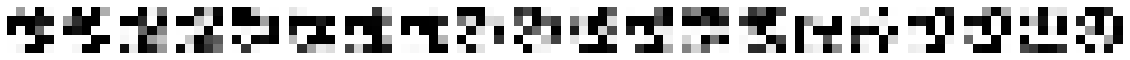

In [82]:
plot_hidden_layer(x_train, grad_weights)

## 17. Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

/Users/anton/Documents/Maga/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


Accuracy on training set: 0.09999999999999998


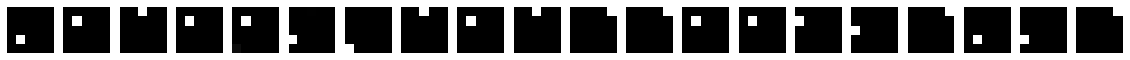

Accuracy on training set: 0.1038


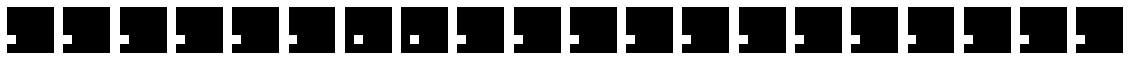

Accuracy on training set: 0.2882


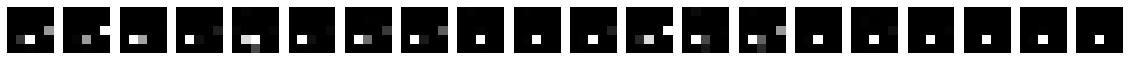

/Users/anton/Documents/Maga/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/anton/Documents/Maga/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Accuracy on training set: 0.8576


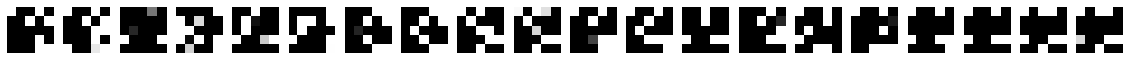

Accuracy on training set: 0.9134


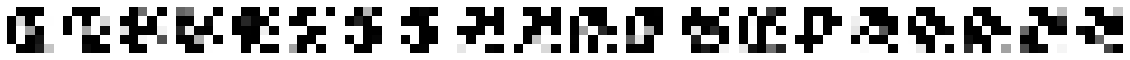

Accuracy on training set: 0.9432


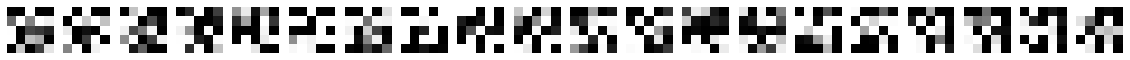

In [85]:
reg_L_list = [1, 0.3, 0.1, 0.03, 0.01, 0.003]
steps = [20, 50, 75, 400, 600, 1000]

for i, reg_l in enumerate(reg_L_list):
    weights_l = train(x_train, y_one_hot, reg_L=reg_l, l_rate=0.5, max_steps=steps[i])
    plot_hidden_layer(x_train, weights_l)

О хорошо подобранном параметре регуляризации свидетельствуют изображения на скрытом слое: чем более разряженны изображения, тем лучше подобран параметр. Высокая точность нейронной сети свидетельствует о хорошо подобранном параметре регуляризации.